<a href="https://colab.research.google.com/github/Gustirobbani/Project-Pribadi/blob/main/Pendeteksi_wajah_untuk_keamanan_pintu_rumah.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


In [ ]:
import torch
print(torch.__version__)

1.11.0+cu113


In [ ]:
! pip install mmcv-full==1.4.5 -f https://download.openmmlab.com/mmcv/dist/cu111/torch1.10.0/index.html

Looking in links: https://download.openmmlab.com/mmcv/dist/cu111/torch1.10.0/index.html


In [ ]:
! pip install mmdet

In [ ]:
! git clone https://github.com/open-mmlab/mmdetection.git

fatal: destination path 'mmdetection' already exists and is not an empty directory.


In [ ]:
import os
import time
import mmcv
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image, ImageDraw

from mmcv import Config
from mmdet.apis import init_detector, inference_detector

# Define available device.
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.device(device)

device(type='cpu')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
os.system("gdown https://drive.google.com/file/d/1XfxdqCyP7BCii17H7nKaHlrcp8UTCN2W/view?usp=sharing")

0

In [ ]:
filepath = "drive/MyDrive/yolov3/archive.zip"

! cp {filepath} ./

In [ ]:
! unzip archive.zip -d my-dataset
! rm archive.zip

Archive:  archive.zip
replace my-dataset/dataset1/dataset1/test/man/face_0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace my-dataset/dataset1/dataset1/test/man/face_0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: my-dataset/dataset1/dataset1/test/man/face_0.jpg  
  inflating: my-dataset/dataset1/dataset1/test/man/face_1.jpg  
  inflating: my-dataset/dataset1/dataset1/test/man/face_10.jpg  
  inflating: my-dataset/dataset1/dataset1/test/man/face_101.jpg  
  inflating: my-dataset/dataset1/dataset1/test/man/face_103.jpg  
  inflating: my-dataset/dataset1/dataset1/test/man/face_104.jpg  
  inflating: my-dataset/dataset1/dataset1/test/man/face_105.jpg  
  inflating: my-dataset/dataset1/dataset1/test/man/face_106.jpg  
  inflating: my-dataset/dataset1/dataset1/test/man/face_107.jpg  
  inflating: my-dataset/dataset1/dataset1/test/man/face_108.jpg  
  inflating: my-dataset/dataset1/dataset1/test/man/face_109.jpg  
  inflating: my-dataset/dataset1

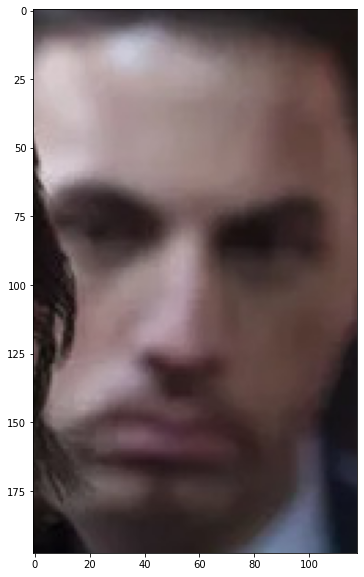

In [ ]:
filename = "face_1000.jpg"
img = Image.open(f"my-dataset/dataset1/dataset1/train/man/{filename}")
draw = ImageDraw.Draw(img)

plt.figure(figsize=(10,10))
plt.imshow(img)
plt.show()

In [ ]:
#preprocesing
for type in ["train", "valid", "test"]:
  CLASSES = ['man', 'woman']
  categories = []; images = []; 
  folder = f"my-dataset/{type}/"

  for index, clazz in enumerate(CLASSES):
    categories.append({"id":index, "name":clazz})
    
    imgId = time.time_ns()
    imgSize = Image.open(f"my-dataset/dataset1/dataset1/train/man/{filename}").size
    images.append(dict(
      id = imgId,
      file_name = filename,
      height = imgSize[0],
      width = imgSize[1],
    ))


  cocoFormatDict = dict(
    categories = categories,
    images = images,
  )

In [ ]:
! mkdir checkpoints
! wget -c https://download.openmmlab.com/mmdetection/v2.0/yolo/yolov3_d53_320_273e_coco/yolov3_d53_320_273e_coco-421362b6.pth \
      -O checkpoints/yolov3_d53_320_273e_coco-421362b6.pth

mkdir: cannot create directory ‘checkpoints’: File exists
--2022-05-20 04:12:59--  https://download.openmmlab.com/mmdetection/v2.0/yolo/yolov3_d53_320_273e_coco/yolov3_d53_320_273e_coco-421362b6.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.254.186.233
Connecting to download.openmmlab.com (download.openmmlab.com)|47.254.186.233|:443... connected.
HTTP request sent, awaiting response... 200 OK

    The file is already fully retrieved; nothing to do.



In [ ]:
cfg = Config.fromfile("mmdetection/configs/yolo/yolov3_d53_320_273e_coco.py")
print(cfg.pretty_text)

checkpoint_config = dict(interval=1)
log_config = dict(interval=50, hooks=[dict(type='TextLoggerHook')])
custom_hooks = [dict(type='NumClassCheckHook')]
dist_params = dict(backend='nccl')
log_level = 'INFO'
load_from = None
resume_from = None
workflow = [('train', 1)]
opencv_num_threads = 0
mp_start_method = 'fork'
auto_scale_lr = dict(enable=False, base_batch_size=64)
model = dict(
    type='YOLOV3',
    backbone=dict(
        type='Darknet',
        depth=53,
        out_indices=(3, 4, 5),
        init_cfg=dict(type='Pretrained', checkpoint='open-mmlab://darknet53')),
    neck=dict(
        type='YOLOV3Neck',
        num_scales=3,
        in_channels=[1024, 512, 256],
        out_channels=[512, 256, 128]),
    bbox_head=dict(
        type='YOLOV3Head',
        num_classes=80,
        in_channels=[512, 256, 128],
        out_channels=[1024, 512, 256],
        anchor_generator=dict(
            type='YOLOAnchorGenerator',
            base_sizes=[[(116, 90), (156, 198), (373, 326)],
   

In [ ]:
def createYOLOv3ConfigFile(classes):
  cfg = Config.fromfile("mmdetection/configs/yolo/yolov3_d53_320_273e_coco.py")

  cfg.load_from = "checkpoints/yolov3_d53_320_273e_coco-421362b6.pth" # Transfer learning from pretrained model.
  cfg.model.bbox_head.num_classes = len(classes) # Number of classes.
  cfg.data.samples_per_gpu = 16 # Batch size.
  cfg.data.workers_per_gpu = 2
  cfg.optimizer = dict(type='AdamW', lr=1e-3, weight_decay=0.1)
  cfg.runner.max_epochs = 10

  cfg.data.train.img_prefix = "my-dataset/train/" # Training data folder
  cfg.data.train.ann_file = "my-dataset/train_annot.json" # Annotation file of training data.
  cfg.data.train.classes = classes

  cfg.data.val.img_prefix = "my-dataset/valid/" # Validation data folder
  cfg.data.val.ann_file = "my-dataset/valid_annot.json" # Annotation file of validation data.
  cfg.data.val.classes = classes

  cfg.data.test.img_prefix = "my-dataset/test/" # Testing data folder
  cfg.data.test.ann_file = "my-dataset/test_annot.json" # Annotation file of testing data.
  cfg.data.test.classes = classes

  cfg.dump("my_yolov3_d53_320_273e_coco.py")

In [ ]:
createYOLOv3ConfigFile(CLASSES)

! python mmdetection/tools/train.py my_yolov3_d53_320_273e_coco.py

No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'
/usr/local/lib/python3.7/dist-packages/mmdet/utils/setup_env.py:39: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting OMP_NUM_THREADS environment variable for each process '
/usr/local/lib/python3.7/dist-packages/mmdet/utils/setup_env.py:49: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting MKL_NUM_THREADS environment variable for each process '
fatal: not a git repository (or any of the parent directories): .git
2022-05-20 04:14:37,630 - mmdet - INFO - Environment info:
------------------------------------------------------------
sys.platform: linux
Python: 3.7.13 

In [ ]:
createYOLOv3ConfigFile(CLASSES)

! python mmdetection/tools/test.py my_yolov3_d53_320_273e_coco.py "work_dirs/my_yolov3_d53_320_273e_coco/epoch_10.pth" --eval bbox

No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'
/usr/local/lib/python3.7/dist-packages/mmdet/utils/setup_env.py:39: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting OMP_NUM_THREADS environment variable for each process '
/usr/local/lib/python3.7/dist-packages/mmdet/utils/setup_env.py:49: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting MKL_NUM_THREADS environment variable for each process '
loading annotations into memory...
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/mmcv/utils/registry.py", line 52, in build_from_cfg
    return obj_cls(**args)
  File "/usr/local/lib/pytho

In [ ]:
imageFile = "my-dataset/dataset1/dataset1/train/man/"
result = inference_detector(model, imageFile)
model.show_result(imageFile, result, out_file="prediction.jpg")

img = Image.open("prediction.jpg")
plt.figure(figsize=(20,20))
plt.imshow(img)
plt.show()

MAAF PAK MASIH ERROR SAYA JUGA BINGUNG